We now investigate the early evolution of the wave front for different classes of initial population distribution. Consider three different initial profiles:

1.  $\rho_0(x) = A_1e^x(1 - x)$;
2.  $\rho_0(x) = A_2e^{2x}(1 - x)^2;
3.  $\rho_0(x) = A_3e^{3x}(1 - x)^3;
where $A_i$ are numerical constants characterising the total initial population.



---

The motion of the wave front is governed by the boundary condition
\begin{equation}
    \dot{s}(t) = -\rho_x(s(t), t).
\end{equation}
We are interested in the initial velocity $\dot{s}(0)$. To find this, we evaluate the above relationship at $t = 0$ where $s(0) = 1$,
\begin{equation}
    \dot{s}(0) = -\rho_x(s(0), 0) = -\rho_0'(1).
\end{equation}
For the initial distribution $\rho_0(x) = A_1e^x(1 - x)$, its derivative is
\begin{align}
    \rho_0'(x)
    &= \frac{d}{dx}(A_1e^x(1 - x)) \\
    &= A_1(e^x(1 - x) + e^x(-1)) \\
    &= A_1(e^x - xe^x - e^x) = -A_1xe^x.
\end{align}
At $x = 1$, we have $\rho_0'(1) = -A_1(1)e^1 = -A_1e$, hence
\begin{equation}
    \dot{s}(0) = -(-A_1e) = A_1e.
\end{equation}
This tells us that the initial velocity of the wave front should be linearly proportional to the coefficient $A_1$.

A1 = 0.1,  s_dot(0) = 0.2718
A1 = 0.2,  s_dot(0) = 0.5436
A1 = 0.3,  s_dot(0) = 0.8154
A1 = 0.4,  s_dot(0) = 1.0872
A1 = 0.5,  s_dot(0) = 1.3590
A1 = 0.6,  s_dot(0) = 1.6308
A1 = 0.7,  s_dot(0) = 1.9026
A1 = 0.8,  s_dot(0) = 2.1744
A1 = 0.9,  s_dot(0) = 2.4462


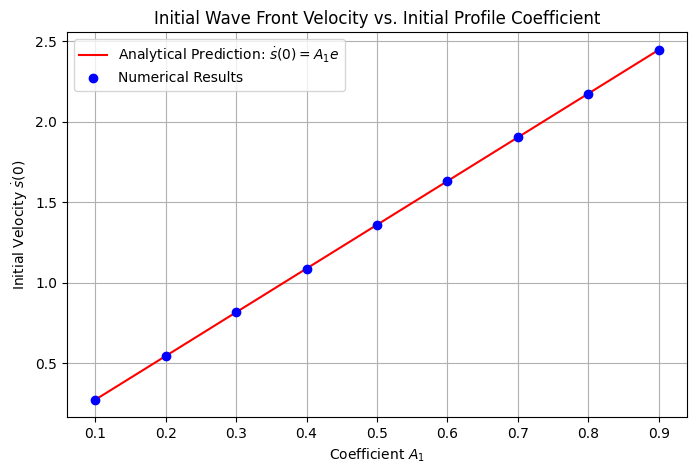

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def get_initial_velocity(A1, N=100, dt=0.0001, t_max=0.5):
    '''
    Runs the simulation for a short time and returns the initial velocity.
    '''
    dy = 1.0 / N
    y = np.linspace(0, 1, N + 1)
    rho = A1 * np.exp(y) * (1 - y)
    rho[N] = 0
    s = 1.0

    # We only need the first step to find the initial velocity
    s_dot_initial = (1 / s) * (4 * rho[N-1] - rho[N-2]) / (2 * dy)

    # Perform a stability check run for one step
    s_dot_check = s_dot_initial
    s_next = s + dt * s_dot_check
    rho_next = np.zeros_like(rho)
    for n in range(1, N):
        diffusion = (1/(2*s**2)) * (rho[n+1]**2 - 2*rho[n]**2 + rho[n-1]**2) / dy**2
        convection = (s_dot_check*y[n]/s) * (rho[n+1] - rho[n-1]) / (2*dy)
        reaction = rho[n]*(1-rho[n])
        rho_next[n] = rho[n] + dt * (diffusion + convection + reaction)

    # If the solution blows up immediately, then it is unstable
    if np.any(np.isnan(rho_next)) or np.max(rho_next) > 1.5:
        # Return a flag indicating instability
        return -1

    return s_dot_initial

A1_values = np.linspace(0.1, 0.9, 9)
initial_velocities_numerical = []

for A1 in A1_values:
    # Initial attempt with standard dt
    dt_sim = 0.0001
    s_dot_0 = get_initial_velocity(A1, dt=dt_sim)
    # If unstable, reduce dt and try again
    if s_dot_0 == -1:
        print(f"Instability detected for A1 = {A1:.1f} with dt = {dt_sim}. Reducing dt.")
        dt_sim = 0.00002
        s_dot_0 = get_initial_velocity(A1, dt=dt_sim)
        print(f"  Success with dt = {dt_sim}")

    initial_velocities_numerical.append(s_dot_0)
    print(f"A1 = {A1:.1f},  s_dot(0) = {s_dot_0:.4f}")

initial_velocities_analytical = A1_values * np.exp(1)
plt.figure(figsize=(8, 5))
plt.plot(A1_values, initial_velocities_analytical, 'r-',
            label=f'Analytical Prediction: $\\dot{{s}}(0) = A_1e$')
plt.plot(A1_values, initial_velocities_numerical, 'bo',
            label='Numerical Results')

plt.title(f'Initial Wave Front Velocity vs. Initial Profile Coefficient')
plt.xlabel(f'Coefficient $A_1$')
plt.ylabel(f'Initial Velocity $\\dot{{s}}(0)$')
plt.grid(True)
plt.legend()
plt.show()

For the second initial distribution $\rho_0(x) = A_2e^{2x}(1 - x)^2$, the derivative is
\begin{equation}
    $\rho_0'(x) = -2A_2xe^{2x}(1 - x).
\end{equation}
Evaluating this at $x=1$ gives $\rho_0'(1) = 0$. This predicts that for any value of $A_2$, the initial velocity of the wave front should be zero. The front starts at rest and must accelerate.

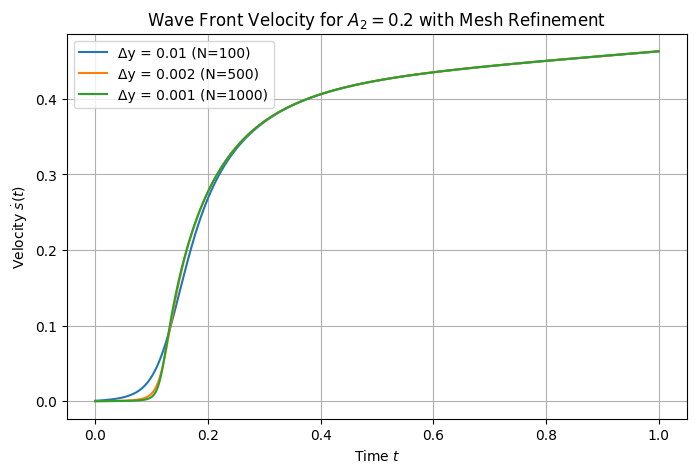

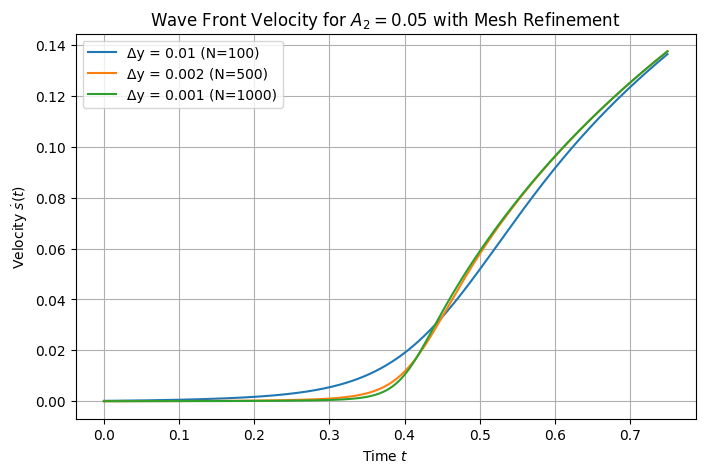

In [35]:
def initial_condition_ii(A, y):
    return A * np.exp(2 * y) * (1 - y)**2

def run_simulation(A_val, N, dt, t_max, initial_condition_func):
    '''
    Runs the full simulation.
    '''
    #  Initialisation
    dy = 1.0 / N
    y = np.linspace(0, 1, N + 1)
    rho = initial_condition_func(A_val, y)
    rho[N] = 0  # Enforce rho(y=1) = 0
    s = 1.0

    # Data storage for plotting
    num_steps = int(t_max / dt)
    sample_rate = max(1, int(num_steps / 2000)) # Store max 2000 points
    time_history = []
    s_dot_history = []

    #  Main Time-Stepping Loop
    for j in range(num_steps + 1):
        t = j * dt

        # Calculate s_dot using the second-order backward difference
        s_dot = (1 / s) * (4 * rho[N-1] - rho[N-2]) / (2 * dy)

        # Store data at the specified sample rate
        if j % sample_rate == 0:
            time_history.append(t)
            s_dot_history.append(s_dot)

        #  Vectorised calculation for the next rho
        rho_next = np.zeros_like(rho)

        # Slices for interior points (from index 1 to N-1)
        interior = slice(1, N)

        # Calculate terms for all interior points at once
        rho_sq = rho**2

        diffusion = (1/(2*s**2)) * (rho_sq[2:] - 2*rho_sq[1:-1] + rho_sq[:-2]) / dy**2
        convection = (s_dot * y[1:-1] / s) * (rho[2:] - rho[:-2]) / (2 * dy)
        reaction = rho[1:-1] * (1 - rho[1:-1])

        # Update all interior points of rho_next using forward Euler
        rho_next[interior] = rho[interior] + dt * (diffusion + convection + reaction)

        #  Apply boundary conditions
        rho_next[0] = rho_next[1]  # rho_y(0,t) = 0
        rho_next[N] = 0            # rho(1,t) = 0

        #  Update state for the next iteration
        rho = rho_next
        s = s + dt * s_dot

    return np.array(time_history), np.array(s_dot_history)

# dt values are chosen to satisfy stability: dt << dy^2 / (some constant)
params_A2_02 = [
    {'N': 100,  'dt': 1e-4,  'label': 'Δy = 0.01 (N=100)'},
    {'N': 500,  'dt': 4e-6,  'label': 'Δy = 0.002 (N=500)'},
    {'N': 1000, 'dt': 1e-6, 'label': 'Δy = 0.001 (N=1000)'},
]

plt.figure(figsize=(8, 5))
for p in params_A2_02:
    time, s_dot = run_simulation(0.2, p['N'], p['dt'], 1.0, initial_condition_ii)
    plt.plot(time, s_dot, label=p['label'])

plt.title(f'Wave Front Velocity for $A_2 = 0.2$ with Mesh Refinement')
plt.xlabel(f'Time $t$')
plt.ylabel(f'Velocity $\\dot{{s}}(t)$')
plt.legend()
plt.grid(True)
plt.show()

params_A2_005 = [
    {'N': 100,  'dt': 1e-4,  'label': 'Δy = 0.01 (N=100)'},
    {'N': 500,  'dt': 4e-6,  'label': 'Δy = 0.002 (N=500)'},
    {'N': 1000, 'dt': 1e-6, 'label': 'Δy = 0.001 (N=1000)'},
]

plt.figure(figsize=(8, 5))
for p in params_A2_005:
    time, s_dot = run_simulation(0.05, p['N'], p['dt'], 0.75, initial_condition_ii)
    plt.plot(time, s_dot, label=p['label'])

plt.title(f'Wave Front Velocity for $A_2 = 0.05$ with Mesh Refinement')
plt.xlabel(f'Time $t$')
plt.ylabel(f'Velocity $\\dot{{s}}(t)$')
plt.legend()
plt.grid(True)
plt.show()

In the case where $A_2 = 0.2$, as the mesh is refined, the curves converge and the 'kinks' become more pronounced. The wave front starts from rest $\dot{s}(0) = 0$ and immediately accelerates. After reaching a peak gradient, it then decelerates to a constant speed again. This indicates that the wave is evolving from its initial transient behavior towards a stable travelling wave with a constant velocity.

Looking at the case $A_2 = 0.05$, the qualitative behavior is similar to the previous case. However, the initial acceleration is lower, reaching a peak much later and also has a larger delay in the deceleration. In general, the entire evolusion is more sluggish due to the smaller initial population taking longer to drive the front expansion.

In both cases, since the initial profile has $\rho_0'(1) = 0$, there is no initial gradient at the front to drive it forward. The movement only starts as the population behind the front $x < 1$ grows and diffuses.

---

Analysis suggests that for some classes of initial distributions, the population front is fixed until a certain waiting time $t_w$ has elapsed, after which the population expands. For initial distributions which are locally quadratic in the vicinity of the wavefront, it can be shown that the waiting time is given by
\begin{equation}
    t_w = \log\left(1 + \frac{1}{6g_2}\right)
\end{equation}
where $\rho_0(x) \sim g_2(1-x)^2$, as $x \to 1$. To find the behavior as $x \to 1$, we can replace the $e^{2x}$ term with its value at $x = 1$, which is $e^2$, hence
\begin{equation}
    \rho_0(x) \sim A_2e^2(1 - x)^2.
\end{equation}
By comparing this to the above form, we can directly identify the coefficient $g_2 = A_2e^2$. Now we can substitute our expression for $g_2$ into the formula for $t_w$,
*   $A_2 = 0.2$: $g_2 \approx 1.4778 \implies t_w \approx 0.107$.
*   $A_2 = 0.05$: $g_2 = \approx 0.3695 \implies t_w \approx 0.372$.

A reasonable interpretation from our numerical results is the time at the maximum rate of change of acceleration, i.e. the jerk.

The occurrence of a waiting time is a direct consequence of the shape of the initial population profile at the wave front. The key property of an initial profile that is locally quadratic is that it approaches zero very flatly. Its spatial derivative is zero at the front, $\rho_0'(1) = 0$. The velocity of the wave front is driven by the population gradient at that point, according to the relation $\dot{s}(t) = -\rho_x(s(t), t)$. At time $t=0$, this means $\dot{s}(0) = -\rho_0'(1) = 0$. The wave front starts at rest.

The population behind the front is not static. It grows according to the reaction term $\rho(1-\rho)$. This term causes the population density to increase in the regions where $0 < \rho < 1$. As the population density just behind the front $x < 1$ increases due to this local growth, the population profile becomes steeper. This process creates a non-zero, negative gradient $\rho_x < 0$ at the edge of the front. Once this gradient has built up to a significant level, $\dot{s} = -\rho_x$ becomes positive, and the front begins to move forward. This is precisely the waiting time $t_w$.

---

For the final initial distribution $\rho_0(x) = A_3e^{3x}(1 - x)^3$, the derivative is $\rho_0'(x) = -3A_3xe^{3x}(1-x)^2$. Evaluating this at $x=1$ once again gives $\rho_0'(1) = 0$. We hypothesize that the increased flatness will lead to an even longer waiting time before the front starts moving significantly.

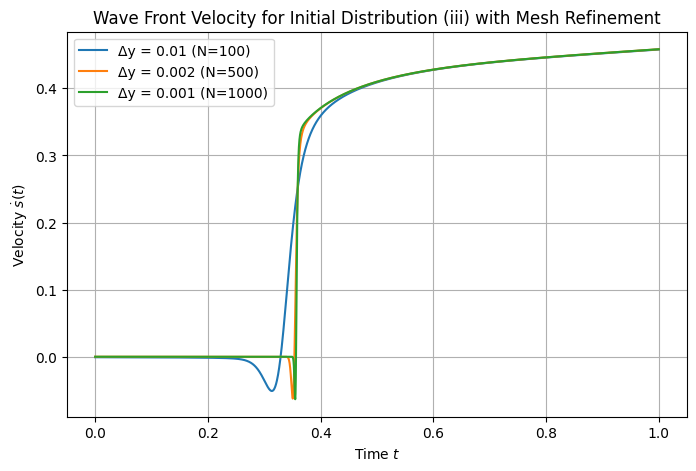

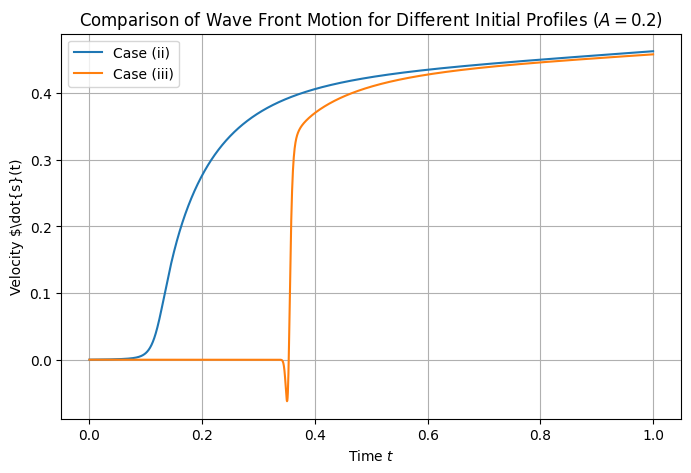

In [39]:
def initial_condition_iii(A, y):
    return A * np.exp(3 * y) * (1 - y)**3

A_val = 0.2
t_max_sim = 1.0

params_A3_02 = [
    {'N': 100,  'dt': 1e-4,  'label': 'Δy = 0.01 (N=100)'},
    {'N': 500,  'dt': 4e-6,  'label': 'Δy = 0.002 (N=500)'},
    {'N': 1000, 'dt': 1e-6, 'label': 'Δy = 0.001 (N=1000)'},
]

plt.figure(figsize=(8, 5))
for p in params_A3_02:
    time, s_dot = run_simulation(A_val, p['N'], p['dt'], t_max_sim, initial_condition_iii)
    plt.plot(time, s_dot, label=p['label'])

plt.title('Wave Front Velocity for Initial Distribution (iii) with Mesh Refinement')
plt.xlabel(f'Time $t$')
plt.ylabel(f'Velocity $\\dot{{s}}(t)$')
plt.legend()
plt.grid(True)
plt.show()

N_refined = 500
dt_refined = 4e-6

time_ii, s_dot_ii = run_simulation(A_val, N_refined, dt_refined, t_max_sim, initial_condition_ii)
time_iii, s_dot_iii = run_simulation(A_val, N_refined, dt_refined, t_max_sim, initial_condition_iii)

plt.figure(figsize=(8, 5))
plt.plot(time_ii, s_dot_ii, label='Case (ii)')
plt.plot(time_iii, s_dot_iii, label='Case (iii)')

plt.title('Comparison of Wave Front Motion for Different Initial Profiles ($A=0.2$)')
plt.xlabel(f'Time $t$')
plt.ylabel(f'Velocity $\\dot{{s}}(t)')
plt.legend()
plt.grid(True)
plt.show()

As the mesh size is reduced, the calculated velocity onverges to a smooth, consistent curve. The slight dip near the waiting time is due to a numerical artifact. This becomes less pronounced as we make the mesh finer.

While both fronts start from rest $\dot{s}(0) = 0$, the front in the third case remains almost stationary for a much longer period. When the front finally does begin to move, its acceleration is significantly higher than that of the second case. In general, the behaviour is delayed in the third initial condition.